In [1]:
# !pip uninstall -y keras

In [2]:
# pip install keras==1.2.2

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
import moviepy
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box


Using TensorFlow backend.


## construct the tiny-yolo model ##

In [4]:
keras.backend.set_image_dim_ordering('th')

In [5]:

feature_layers = [
    Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(32,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2),border_mode='valid'),
    Convolution2D(64,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2),border_mode='valid'),
    Convolution2D(128,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2),border_mode='valid'),
    Convolution2D(256,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2),border_mode='valid'),
    Convolution2D(512,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2),border_mode='valid'),
    Convolution2D(1024,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    Convolution2D(1024,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    Convolution2D(1024,3,3 ,border_mode='same'),
    LeakyReLU(alpha=0.1),
    Flatten(),
    Dense(256),
    Dense(4096),
    LeakyReLU(alpha=0.1)
]

classification_layers = [Dense(1470)]
model = Sequential(feature_layers + classification_layers)
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## load weight from pretrained weights for yolo ##
The weight file can be downloaded from https://pjreddie.com/darknet/yolo/

In [7]:
load_weights(model,'yolo-tiny.weights')

In [8]:
# inputs = []
# label = []
# with open("test.pkl", 'rb') as handle:
#     data = pickle.load(handle)
#     inputs = data['x']
#     label = data['y']
    
    
# batch = []
# for input1 in inputs:
#     newin = np.transpose(cv2.resize(input1[300:650,500:,:],(448,448)),(2,0,1))
#     batch.append(newin)

# batch = np.array(batch)

# batch = 2 * (batch/255.) - 1

# model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])

# model.fit(batch, label,batch_size=1,nb_epoch= 5,verbose=1,validation_data=(batch, label))

## apply the model to a test image ##

In [9]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image
resized = cv2.resize(image_crop,(448,448))

In [10]:
print(image.shape)
print(image_crop.shape)
print(resized.shape)

(720, 1280, 3)
(720, 1280, 3)
(448, 448, 3)


In [11]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)
out
# # array([[0.07029423, 0.0017971 , 0.06053229, ..., 0.25104368, 0.20336428,
#         0.33573964]], dtype=float32)

array([[0.07029423, 0.0017971 , 0.06053229, ..., 0.25104368, 0.20336428,
        0.33573964]], dtype=float32)

interpolate the vector out from the neural network, generate the boxes

In [12]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.19)

In [13]:
# def draw_box(boxes,im,crop_dim):
#     imgcv = im
#     [xmin,xmax] = crop_dim[0]
#     [ymin,ymax] = crop_dim[1]
#     for b in boxes:
#         if np.isnan(b.w)==True:
#             continue
#         if np.isnan(b.h)==True:
#             continue
# #         if np.isnan(b.h)==True:
# #             continue
            
#         h, w, _ = imgcv.shape
#         left  = int ((b.x - b.w/2.) * w)
#         right = int ((b.x + b.w/2.) * w)
#         top   = int ((b.y - b.h/2.) * h)
#         bot   = int ((b.y + b.h/2.) * h)
#         left = int(left*(xmax-xmin)/w + xmin)
#         right = int(right*(xmax-xmin)/w + xmin)
#         top = int(top*(ymax-ymin)/h + ymin)
#         bot = int(bot*(ymax-ymin)/h + ymin)

#         if left  < 0    :  left = 0
#         if right > w - 1: right = w - 1
#         if top   < 0    :   top = 0
#         if bot   > h - 1:   bot = h - 1
#         thick = int((h + w) // 150)
#         cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)

#     return imgcv


visualize the box on the original image

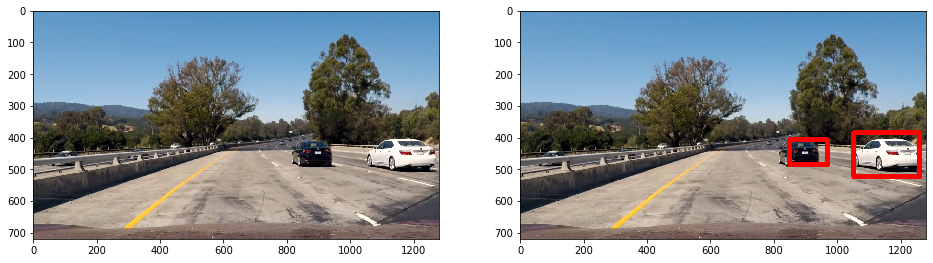

In [14]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[0,1280],[0,720]]))

more examples

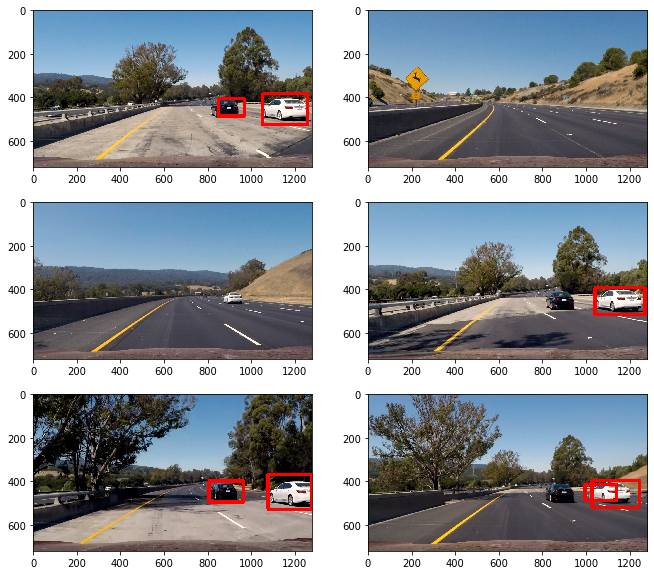

In [23]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[:,:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.23)
    ax.imshow(draw_box(boxes,images[i],[[0,1280],[0,720]]))

## apply to video ##

In [16]:
def frame_func(image):
    crop = image[:,:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.2)
    return draw_box(boxes,image,[[0,1280],[0,720]])

In [17]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip2 = VideoFileClip("./car-detection.mp4")

In [18]:
print(clip1.size)
print(clip2.size)

[1280, 720]
[768, 432]


In [19]:
clip2 = moviepy.video.fx.all.resize(clip2, newsize=None, height=720, width=1280, apply_to_mask=True)

In [20]:
lane_clip = clip2.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

t:   0%|          | 0/378 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
Wall time: 40.8 s
